In this notebook, I use TyXe and Pyro to implement VCL on RNNs. The dataset is split (stroke) MNIST dataset. 

In [ ]:
device = "cuda" 

## install packages

In [ ]:
! pip install pyro-ppl
! git clone https://github.com/TyXe-BDL/TyXe.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 39.6 MB/s eta 0:00:00
Cloning into 'TyXe'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 363 (delta 51), reused 50 (delta 50), pack-reused 296
Receiving objects: 100% (363/363), 4.19 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (173/173), done.


## Import Packages

In [ ]:
%cd /content/TyXe

/content/TyXe


In [ ]:
import os
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from torchvision.models import resnet18
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

import tyxe
import functools

import pyro
import pyro.nn as pynn
import pyro.poutine as poutine
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, MCMC

import pyro.infer.autoguide.initialization as ag_init


## Load data

In [ ]:
with open("/content/drive/MyDrive/Advanced Machine Learning Project/Complex_Networks_VCL/strokeMNIST_train_seq.pkl", "rb") as f:
      train_data = pickle.load(f)
with open("/content/drive/MyDrive/Advanced Machine Learning Project/Complex_Networks_VCL/strokeMNIST_test_seq.pkl", "rb") as f:
      test_data = pickle.load(f)  


def get_sMNIST(task_idx, device):
    np.random.seed(task_idx)
    labels = np.array_split(range(0, 10), 5)[task_idx]

    ds_train_filtered = list(filter(lambda item: item[1] in labels, train_data))
    ds_test_filtered = list(filter(lambda item: item[1] in labels, test_data))

    train_x = torch.nn.utils.rnn.pad_sequence([i[0] for i in ds_train_filtered], batch_first=True, padding_value=0.0)
    train_l = [i[0].shape[0] for i in ds_train_filtered]
    train_y = torch.tensor([d[1] - task_idx * 2 for d in ds_train_filtered])
    
    test_x = torch.nn.utils.rnn.pad_sequence([i[0] for i in ds_test_filtered], batch_first=True, padding_value=0.0)
    test_l = [i[0].shape[0] for i in ds_test_filtered]
    test_y = torch.tensor([d[1] - task_idx * 2 for d in ds_test_filtered])

    return train_x.to(device).float(), train_l, train_y.to(device), test_x.to(device).float(), test_l, test_y.to(device)

## Define Networks and Likelihoods

In [ ]:
# define a class, converting the network to a BNN distribution
class ModelBNN(pynn.PyroModule):
    def __init__(self, net, prior, name=""):
        super().__init__(name)
        self.net = net
        pynn.module.to_pyro_module_(self.net)
        self.prior = prior
        self.prior.apply_(self.net)
    def forward(self, *args, **kwargs):
        return self.net(*args, **kwargs)
    def update_prior(self, new_prior):
        self.prior = new_prior
        self.prior.update_(self)

In [ ]:
class MultiHeadLSTM(nn.Module):
    def __init__(self, head_nums):
        super().__init__()
        self.rnn = nn.GRU(4, 128, 8, batch_first=True)
        self.heads = nn.ModuleList([nn.Linear(128*8, 2) for i in range(head_nums)])
    def forward(self, x, length):
        x = torch.nn.utils.rnn.pack_padded_sequence(input=x, 
                                                    lengths=length, 
                                                    batch_first=True, 
                                                    enforce_sorted=False)
        h = nn.Flatten()(self.rnn(x)[1].permute(1, 0, 2))
        logits = torch.cat([i(h)[:, None, :] for i in self.heads], dim=1)
        return logits


In [ ]:
def define_resnet():
    return MultiHeadLSTM(5)

In [ ]:
# define pyro model
def split_MNIST_model(multi_head_net, x, length, y, task_ids, dataset_size, annealing_factor):
    z = multi_head_net(x, length)[np.arange(x.shape[0]), task_ids, :] # reshape the last dimension into 5 heads
    with poutine.scale(None, dataset_size / x.shape[0]):
        with pyro.plate("batch_size", x.shape[0], dim=-1):
            pyro.sample("batch_obs", dist.Categorical(logits=z), obs=y.long())
    return z

In [ ]:
def train_model(train_x, 
                train_y, 
                train_l,
                train_t, 
                batch_size,
                n_epochs,
                pyro_model,
                define_net, 
                last_guide, 
                random_init_guide,
                prior=tyxe.priors.IIDPrior(dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))):
    """
    a function to train BNN
    define_net: python callable, returning a torch nn network
    last_guide: if None, use prior; if not None, use it as prior
    prior: if last_guide is None. use this as the prior
    pyro_model: python callable, defining the pyro model
    """
    
    bnn = ModelBNN(define_net(), prior).to(device) # define the bnn model
    if random_init_guide or last_guide == None:
        guide = functools.partial(
                                  tyxe.guides.AutoNormal,  
                                  init_scale=1e-1,  
                                  init_loc_fn=ag_init.init_to_sample
                                 )(pyro_model)
    else:
        guide = deepcopy(last_guide)
    if last_guide != None:
        site_names = tyxe.util.pyro_sample_sites(bnn)
        bnn.update_prior(tyxe.priors.DictPrior(last_guide.get_detached_distributions(site_names)))
    opt = pyro.optim.ClippedAdam({"lr": 0.001}) 
    svi = SVI(pyro_model, guide, opt, Trace_ELBO())
    dataset_size = train_x.shape[0]


    pyro.clear_param_store()
    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        elbos = []
        for batch in range(int(np.ceil(dataset_size / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            batch_x = train_x[batch_idx0: batch_idx1]
            batch_y = train_y[batch_idx0: batch_idx1]
            batch_t = train_t[batch_idx0: batch_idx1].long()
            batch_l = train_l[batch_idx0: batch_idx1]
            elbo = svi.step(bnn, 
                            x=batch_x, 
                            length=batch_l,
                            y=batch_y, 
                            task_ids=batch_t, 
                            dataset_size=dataset_size, 
                            annealing_factor=1)
            elbos.append(elbo)
        ELBO.append(np.mean(elbos))
    return guide, ELBO


In [ ]:
def prediction(test_x, 
               test_y,
               test_t, 
               test_l,
               define_net, 
               guide,
               n_particles=100):
    prior = tyxe.priors.IIDPrior(dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))
    bnn = ModelBNN(define_net(), prior).to(device) # define the bnn model
    site_names = tyxe.util.pyro_sample_sites(bnn)
    dist_dict = guide.get_detached_distributions(site_names)
    bnn.update_prior(tyxe.priors.DictPrior(dist_dict)) # use the guide as the prior

    pyro.clear_param_store()
    Z = []
    for _ in range(n_particles):  
        z = bnn(test_x, test_l)[np.arange(test_x.shape[0]), test_t, :]
        Z.append(z)
    pred = torch.stack(Z).mean(0).argmax(-1)
    acc = (pred == test_y).cpu().detach().numpy().mean()
    return acc

In [ ]:
batch_size = 256
coreset_size = 40
coreset_x = None
coreset_y = None
coreset_t = None
coreset_l = None


Test_x = []
Test_y = []
Test_t = []
Test_l = []

Accuracies = {}

=================== train task 0 ========================


100%|██████████| 150/150 [16:54<00:00,  6.76s/it]


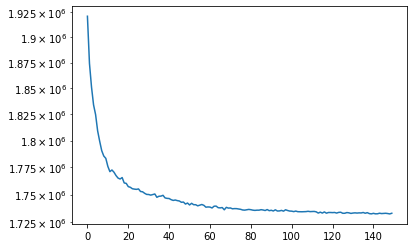

The Accuracies of Propogation Model
[0.9825059101654846]


100%|██████████| 2000/2000 [04:18<00:00,  7.74it/s]


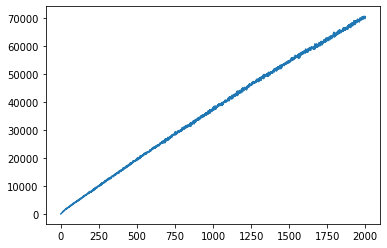

The Accuracies of Predict Model
[0.9801418439716312]
=================== train task 1 ========================


100%|██████████| 150/150 [15:49<00:00,  6.33s/it]


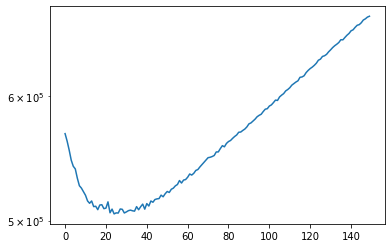

The Accuracies of Propogation Model
[0.9706855791962175, 0.9265426052889324]


100%|██████████| 2000/2000 [04:24<00:00,  7.57it/s]


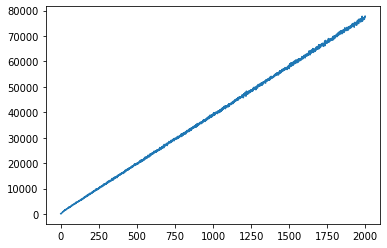

The Accuracies of Predict Model
[0.9645390070921985, 0.9128305582761999]
=================== train task 2 ========================


100%|██████████| 150/150 [14:27<00:00,  5.79s/it]


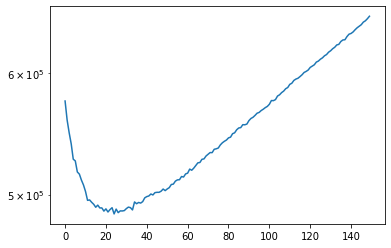

The Accuracies of Propogation Model
[0.9791962174940898, 0.8756121449559255, 0.9439701173959445]


100%|██████████| 2000/2000 [04:31<00:00,  7.36it/s]


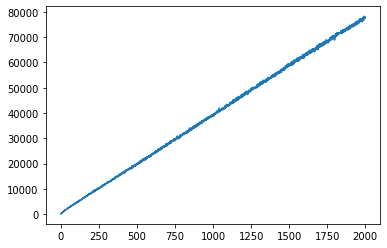

The Accuracies of Predict Model
[0.9777777777777777, 0.9040156709108716, 0.9364994663820705]
=================== train task 3 ========================


100%|██████████| 150/150 [15:54<00:00,  6.36s/it]


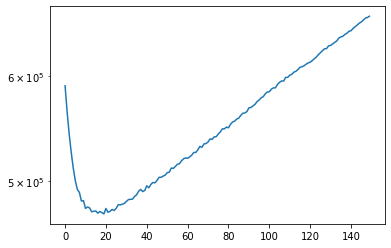

The Accuracies of Propogation Model
[0.9706855791962175, 0.7752203721841332, 0.9343649946638207, 0.9818731117824774]


100%|██████████| 2000/2000 [04:37<00:00,  7.22it/s]


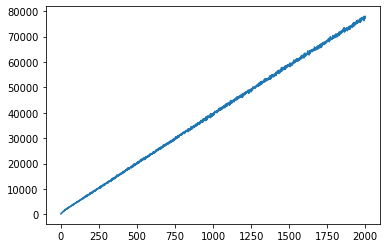

The Accuracies of Predict Model
[0.9787234042553191, 0.871694417238002, 0.9375667022411953, 0.9718026183282981]
=================== train task 4 ========================


100%|██████████| 150/150 [15:39<00:00,  6.26s/it]


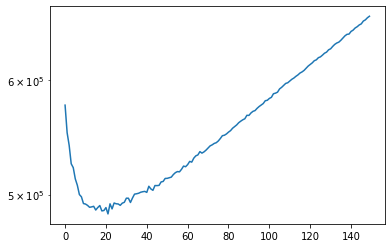

The Accuracies of Propogation Model
[0.9754137115839243, 0.8594515181194907, 0.9381003201707577, 0.9712990936555891, 0.9198184568835098]


100%|██████████| 2000/2000 [04:40<00:00,  7.13it/s]


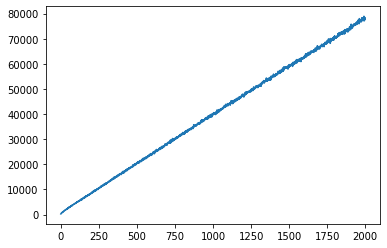

The Accuracies of Predict Model
[0.9735224586288416, 0.8687561214495593, 0.9300960512273212, 0.9572004028197382, 0.9213313161875946]


In [ ]:
for task_idx in range(5):
    print("=================== train task %d ========================"%task_idx)
    train_x, train_l, train_y, test_x, test_l, test_y = get_sMNIST(task_idx, device)

    # select coreset
    coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)

    Test_x.append(test_x)
    Test_y.append(test_y)
    Test_t.append(torch.ones_like(test_y) * task_idx)
    Test_l.append(test_l)

    if coreset_x == None:
        coreset_x = train_x[coreset_idx]
        coreset_y = train_y[coreset_idx]
        coreset_t = torch.ones_like(train_y[coreset_idx]) * task_idx
        coreset_l = np.array(train_l)[coreset_idx].tolist()
    else:
        if train_x[coreset_idx].shape[1] < coreset_x.shape[1]:
            new_coreset_x = torch.cat([train_x[coreset_idx], 
                                       torch.zeros_like(train_x[coreset_idx, :(-train_x[coreset_idx].shape[1]+coreset_x.shape[1])])], 
                                       dim=1)
        elif train_x[coreset_idx].shape[1] > coreset_x.shape[1]:
            new_coreset_x = train_x[coreset_idx]
            coreset_x = torch.cat([coreset_x, 
                                   torch.zeros_like(coreset_x[:, :(-coreset_x.shape[1]+train_x[coreset_idx].shape[1])])
                                   ], 
                                   dim=1)
        else:
            new_coreset_x = train_x[coreset_idx]
        coreset_x = torch.cat([new_coreset_x, coreset_x])
        coreset_y = torch.cat([train_y[coreset_idx], coreset_y])
        coreset_t = torch.cat([torch.ones_like(train_y[coreset_idx]) * task_idx, coreset_t])
        coreset_l = np.array(train_l)[coreset_idx].tolist() + coreset_l


    train_x = train_x[train_idx]
    train_y = train_y[train_idx]
    train_t = torch.ones_like(train_y) * task_idx
    train_l = np.array(train_l)[train_idx].tolist()

    prop_guide, ELBO = train_model(train_x, 
                                   train_y, 
                                   train_l,
                                   train_t, 
                                   batch_size,
                                   n_epochs=150,
                                   pyro_model=split_MNIST_model,
                                   define_net=define_resnet, 
                                   last_guide=prop_guide if task_idx != 0 else None,
                                   random_init_guide=True)# if task_idx == 0 else prop_guide) 
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()


    Acc = []
    for t in range(len(Test_x)):
        acc = prediction(test_x=Test_x[t], 
                         test_y=Test_y[t], 
                         test_l=Test_l[t],
                          test_t=Test_t[t], 
                          define_net=define_resnet, 
                          guide=prop_guide,
                          n_particles=100)
        Acc.append(acc)
    print("The Accuracies of Propogation Model")
    print(Acc)

    

    pred_guide, ELBO = train_model(coreset_x, 
                                   coreset_y, 
                                   coreset_l,
                                   coreset_t, 
                                   batch_size,
                                   n_epochs=2000,
                                   pyro_model=split_MNIST_model,
                                   define_net=define_resnet, 
                                   last_guide=prop_guide,
                                   random_init_guide=False)
    plt.plot(ELBO)
    plt.show()


    Acc = []
    for t in range(len(Test_x)):
        acc = prediction(test_x=Test_x[t], 
                         test_y=Test_y[t], 
                         test_t=Test_t[t], 
                         test_l=Test_l[t],
                         define_net=define_resnet, 
                         guide=pred_guide,
                         n_particles=100)
        Acc.append(acc)
    print("The Accuracies of Predict Model")
    print(Acc)



In [ ]:
from google.colab import runtime
runtime.unassign()